# Train CNN CIFAR10 classifier with Keras

In [2]:
!pip install matplotlib seaborn pandas numpy scipy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

TensorFlow version: 2.1.0
Eager execution is: True
Keras version: 2.2.4-tf


In [4]:
!pwd

/root/keras/tensorflow/keras_experiments/cifar10


# CIFAR-10
The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.



class_names = \[
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
\]

<img src="images/cifar10.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" 
     width=850/>

## CIFAR10 Utilities

In [5]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CHANNELS = 3

In [6]:
def plot_cifar10_image(image, width, height, channels):
    reshaped = image.reshape(width, height, channels)
    plt.figure(figsize=(1,1)),
    plt.imshow(reshaped, cmap=plt.cm.binary)
    plt.axis("off")
    
def plot_cifar10_images(instances, width=IMAGE_WIDTH, height=IMAGE_HEIGHT, channels=NUM_CHANNELS, images_per_row=5, **options):
    plt.figure(figsize=(6,6))

    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(width, height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((width, width * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## Data

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [8]:
print(x_train[0].shape)
print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(y_train.dtype)

(32, 32, 3)
(50000, 32, 32, 3)
uint8
(50000, 1)
uint8


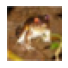

In [9]:
%matplotlib inline
plot_cifar10_image(x_train[0], IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)
plt.show()

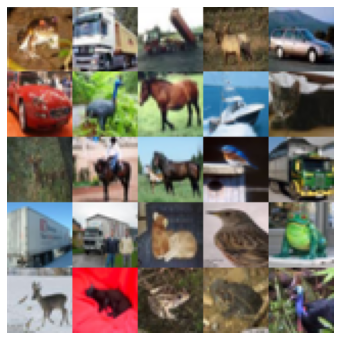

In [10]:
plot_cifar10_images(x_train[0:25], IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)

# Training

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

## Data Normalization

In [12]:
flatten = lambda l: [item for sublist in l for item in sublist]
number_of_classes = len(set(flatten(y_train)))
print("number_of_classes", number_of_classes)

number_of_classes 10


In [13]:
x_train, x_test = tf.cast(x_train, tf.float32), tf.cast(x_test, tf.float32)
y_train, y_test = tf.cast(y_train, tf.uint8), tf.cast(y_test, tf.uint8)
#x_train = x_train / 1.0
#x_test = x_test / 1.0
x_full = np.concatenate((x_train, x_test), axis=0)
print(x_full.shape)

print(type(x_train))
print(x_train.shape)
print(x_train.dtype)
print(y_train.shape)
print(y_train.dtype)

(60000, 32, 32, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(50000, 32, 32, 3)
<dtype: 'float32'>
(50000, 1)
<dtype: 'uint8'>


### Normalise

In [14]:
normalization = Normalization()
normalization.adapt(x_full)

## Train
* C: Convolution layer
* P: Pooling layer
* B: Batch normalization layer
* F: Fully connected layer
* O: Output fully connected softmax layer

In [15]:
# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
if K.image_data_format() == 'channels_first':
    input_shape = (1, IMAGE_WIDTH, IMAGE_HEIGHT)
else:
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS,)

### Tensorboard callback

In [16]:
# tensorboard --logdir=/full_path_to_your_logs

import os
log_dir = os.getcwd() + os.path.sep + "logs"
print(log_dir)

/root/keras/tensorflow/keras_experiments/cifar10/logs


In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    write_graph=True,
    write_images=True,
    histogram_freq=1,  # How often to log histogram visualizations
    embeddings_freq=1,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

### Early stop callback

In [23]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

### Trainer

In [24]:
batch_size = 300
number_of_epochs = 50
validation_split = 0.2
verbosity = 1
use_multiprocessing = True
workers = 4

l2_loss_lambda = 0.010
kernel_regularizer = regularizers.l2(l2_loss_lambda)

def train(model, x, y):
    model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.sparse_categorical_crossentropy, 
        metrics=['accuracy']
    )
    history = model.fit(
        x, 
        y,
        shuffle=True,
        batch_size=batch_size,
        epochs=number_of_epochs,
        validation_split=validation_split,
        use_multiprocessing=use_multiprocessing,
        workers=workers,
        verbose=verbosity,
        callbacks=[
            tensorboard_callback,
            earlystop_callback
        ]
    )
    return(history)

### Train CPBFO model  (F/ReLU/He)

In [25]:
model = Sequential([
    #normalization,
    BatchNormalization(
        name="input_normalization"
    ),
    Conv2D(
        name="conv01",
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(
        name="pool01",
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(
        name="batch_before_full01"
    ),
    Dense(
        name="full01", 
        units=300, 
        activation="relu"
    ),     # Fully connected layer 
    Dense(
        name="output_softmax", 
        units=number_of_classes, 
        activation="softmax"
    )
])

history = train(model, x_train, y_train)
print(history)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 4s 94us/sample - loss: 1.9355 - accuracy: 0.4923 - val_loss: 1.5786 - val_accuracy: 0.4811
Epoch 2/50
40000/40000 [==============================] - 3s 70us/sample - loss: 0.8970 - accuracy: 0.6971 - val_loss: 1.2314 - val_accuracy: 0.5817
Epoch 3/50
40000/40000 [==============================] - 3s 69us/sample - loss: 0.5467 - accuracy: 0.8113 - val_loss: 1.0901 - val_accuracy: 0.6250
Epoch 4/50
40000/40000 [==============================] - 3s 65us/sample - loss: 0.3410 - accuracy: 0.8876 - val_loss: 1.1267 - val_accuracy: 0.6435
Epoch 5/50
40000/40000 [==============================] - 3s 69us/sample - loss: 0.2069 - accuracy: 0.9366 - val_loss: 1.2120 - val_accuracy: 0.6587
Epoch 6/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.1248 - accuracy: 0.9675 - val_loss: 1.3078 - val_accuracy: 0.6637
Epoch 7/50
40000/40000 [==============================] 

### Train CPBCPBFO model (F/ReLU/He)

In [26]:
model = Sequential([
#    normalization,
    BatchNormalization(
        name="input_normalization"
    ),
    Conv2D(
        name="conv_01",
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(300, activation="relu"),                    # Fully connected layer 
    Dense(number_of_classes, activation="softmax")
])
model.layers

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 3s 82us/sample - loss: 1.4357 - accuracy: 0.5415 - val_loss: 3.0819 - val_accuracy: 0.1568
Epoch 2/50
40000/40000 [==============================] - 2s 61us/sample - loss: 0.7682 - accuracy: 0.7332 - val_loss: 2.5424 - val_accuracy: 0.3205
Epoch 3/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.5030 - accuracy: 0.8265 - val_loss: 1.3555 - val_accuracy: 0.5757
Epoch 4/50
40000/40000 [==============================] - 2s 61us/sample - loss: 0.3105 - accuracy: 0.9003 - val_loss: 1.1700 - val_accuracy: 0.6496
Epoch 5/50
40000/40000 [==============================] - 3s 64us/sample - loss: 0.1917 - accuracy: 0.9429 - val_loss: 1.0342 - val_accuracy: 0.7010
Epoch 6/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.1053 - accuracy: 0.9749 - val_loss: 1.0795 - val_accuracy: 0.7099
Epoch 7/50
40000/40000 [==============================] 

### Train CPBCPBFBFO model (F/ReLU/He)

In [27]:
model = Sequential([
#    normalization,
    BatchNormalization(
        name="input_normalization"
    ),
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(300, activation="relu"),                    # Fully connected layer 
    BatchNormalization(),
    Dense(200, activation="relu"),                    # Fully connected layer 
    Dense(number_of_classes, activation="softmax")    # Output layer
])

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 3s 84us/sample - loss: 1.2708 - accuracy: 0.5525 - val_loss: 2.3313 - val_accuracy: 0.2517
Epoch 2/50
40000/40000 [==============================] - 3s 65us/sample - loss: 0.7994 - accuracy: 0.7206 - val_loss: 1.9056 - val_accuracy: 0.3840
Epoch 3/50
40000/40000 [==============================] - 3s 68us/sample - loss: 0.5537 - accuracy: 0.8102 - val_loss: 1.2302 - val_accuracy: 0.5919
Epoch 4/50
40000/40000 [==============================] - 3s 68us/sample - loss: 0.3550 - accuracy: 0.8848 - val_loss: 0.9753 - val_accuracy: 0.6875
Epoch 5/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.2081 - accuracy: 0.9370 - val_loss: 1.0243 - val_accuracy: 0.7042
Epoch 6/50
40000/40000 [==============================] - 3s 64us/sample - loss: 0.1189 - accuracy: 0.9665 - val_loss: 1.0937 - val_accuracy: 0.7014
Epoch 7/50
40000/40000 [==============================] 

### Train CPBCPBCPBFBFO model (F/ReLU/He)

In [28]:
model = Sequential([
#    normalization,
    BatchNormalization(
        name="input_normalization"
    ),
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(300, activation="relu"),                    # Fully connected layer 
    BatchNormalization(),
    Dense(200, activation="relu"),                    # Fully connected layer 
    Dense(number_of_classes, activation="softmax")    # Output layer
])

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 4s 99us/sample - loss: 1.2629 - accuracy: 0.5518 - val_loss: 3.6097 - val_accuracy: 0.1628
Epoch 2/50
40000/40000 [==============================] - 3s 71us/sample - loss: 0.8061 - accuracy: 0.7176 - val_loss: 2.2436 - val_accuracy: 0.3400
Epoch 3/50
40000/40000 [==============================] - 3s 70us/sample - loss: 0.5876 - accuracy: 0.7962 - val_loss: 1.1539 - val_accuracy: 0.6319
Epoch 4/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.4192 - accuracy: 0.8573 - val_loss: 0.8288 - val_accuracy: 0.7232
Epoch 5/50
40000/40000 [==============================] - 3s 72us/sample - loss: 0.2826 - accuracy: 0.9071 - val_loss: 0.8943 - val_accuracy: 0.7214
Epoch 6/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.1886 - accuracy: 0.9409 - val_loss: 0.9313 - val_accuracy: 0.7370
Epoch 7/50
40000/40000 [==============================] 

In [41]:
model = Sequential([
    BatchNormalization(
        name="input_normalization"
    ),
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Dropout(0.20),
    
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Dropout(0.20),
    Flatten(),                                        # 3D shape to 1D.

    BatchNormalization(),
    Dense(300, activation="relu"),                    # Fully connected layer 
    Dropout(0.20),

    BatchNormalization(),
    Dense(200, activation="relu"),                    # Fully connected layer 
    Dense(number_of_classes, activation="softmax")    # Output layer
])

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 4s 100us/sample - loss: 1.4804 - accuracy: 0.4679 - val_loss: 3.6420 - val_accuracy: 0.1073
Epoch 2/50
40000/40000 [==============================] - 3s 69us/sample - loss: 1.0894 - accuracy: 0.6103 - val_loss: 3.5951 - val_accuracy: 0.1735
Epoch 3/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.9274 - accuracy: 0.6702 - val_loss: 1.4351 - val_accuracy: 0.5240
Epoch 4/50
40000/40000 [==============================] - 3s 69us/sample - loss: 0.8157 - accuracy: 0.7103 - val_loss: 0.8896 - val_accuracy: 0.6889
Epoch 5/50
40000/40000 [==============================] - 3s 69us/sample - loss: 0.7353 - accuracy: 0.7395 - val_loss: 0.8379 - val_accuracy: 0.7114
Epoch 6/50
40000/40000 [==============================] - 3s 70us/sample - loss: 0.6669 - accuracy: 0.7630 - val_loss: 0.7575 - val_accuracy: 0.7397
Epoch 7/50
40000/40000 [==============================]

## Train NCPBCP(BC)+P(BF)+O model (F/ReLU/He)

In [29]:
model = Sequential([
#    normalization,
    BatchNormalization(
        name="input_normalization"
    ),
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape,
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape

    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(
        units=300, 
        kernel_regularizer=kernel_regularizer,
        activation="relu"
    ),                    # Fully connected layer 
    BatchNormalization(),
    Dense(
        units=200, 
        kernel_regularizer=kernel_regularizer,
        activation="relu"
    ),                    # Fully connected layer 
    Dense(number_of_classes, activation="softmax")    # Output layer
])

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 7s 171us/sample - loss: 10.3018 - accuracy: 0.4948 - val_loss: 6.6125 - val_accuracy: 0.1016
Epoch 2/50
40000/40000 [==============================] - 5s 129us/sample - loss: 3.2964 - accuracy: 0.6441 - val_loss: 4.1067 - val_accuracy: 0.1058
Epoch 3/50
40000/40000 [==============================] - 5s 130us/sample - loss: 1.8091 - accuracy: 0.6872 - val_loss: 2.5234 - val_accuracy: 0.3945
Epoch 4/50
40000/40000 [==============================] - 5s 126us/sample - loss: 1.4597 - accuracy: 0.7058 - val_loss: 1.7004 - val_accuracy: 0.6059
Epoch 5/50
40000/40000 [==============================] - 5s 128us/sample - loss: 1.3373 - accuracy: 0.7245 - val_loss: 1.5114 - val_accuracy: 0.6583
Epoch 6/50
40000/40000 [==============================] - 5s 126us/sample - loss: 1.2898 - accuracy: 0.7360 - val_loss: 1.4674 - val_accuracy: 0.6761
Epoch 7/50
40000/40000 [=========================

## Train NCPBCP(BC)+P(BF)+O model (F/ReLU/He) + Drop outs

In [33]:
model = Sequential([
#    normalization,
    BatchNormalization(
        name="input_normalization"
    ),
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Dropout(0.20),
    
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape,
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape

    ),
    Dropout(0.20),
    
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=128, 
        kernel_size=(3, 3), 
        kernel_regularizer=kernel_regularizer,
        strides=(1, 1), 
        padding="same",
        activation='relu', 
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Dropout(0.20),
    
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(
        units=300, 
        kernel_regularizer=kernel_regularizer,
        activation="relu"
    ),                    # Fully connected layer 
    Dropout(0.20),
    
    BatchNormalization(),
    Dense(
        units=200, 
        kernel_regularizer=kernel_regularizer,
        activation="relu"
    ),                    # Fully connected layer 
    
    Dense(number_of_classes, activation="softmax")    # Output layer
])

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=300)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 7s 173us/sample - loss: 10.3409 - accuracy: 0.4443 - val_loss: 6.5619 - val_accuracy: 0.1494
Epoch 2/50
40000/40000 [==============================] - 5s 131us/sample - loss: 3.2982 - accuracy: 0.5881 - val_loss: 4.0299 - val_accuracy: 0.1197
Epoch 3/50
40000/40000 [==============================] - 5s 127us/sample - loss: 1.8619 - accuracy: 0.6397 - val_loss: 2.5570 - val_accuracy: 0.3674
Epoch 4/50
40000/40000 [==============================] - 5s 128us/sample - loss: 1.5457 - accuracy: 0.6700 - val_loss: 1.7305 - val_accuracy: 0.5865
Epoch 5/50
40000/40000 [==============================] - 5s 127us/sample - loss: 1.4357 - accuracy: 0.6882 - val_loss: 1.5059 - val_accuracy: 0.6658
Epoch 6/50
40000/40000 [==============================] - 5s 125us/sample - loss: 1.3922 - accuracy: 0.7017 - val_loss: 1.5002 - val_accuracy: 0.6583
Epoch 7/50
40000/40000 [=========================

### Train CPBFO model  (F/SELU/LeCun)
SELU activation + LeCun initialization at Fully connected layer

In [30]:
model = Sequential([
    normalization,
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', 
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(
        300, 
        kernel_initializer='lecun_normal', 
        activation='selu'
    ),                    # Fully connected layer 
    Dense(
        number_of_classes, 
        activation="softmax"
    )
])

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 3s 78us/sample - loss: 2.7482 - accuracy: 0.4676 - val_loss: 1.7814 - val_accuracy: 0.5025
Epoch 2/50
40000/40000 [==============================] - 3s 68us/sample - loss: 1.2003 - accuracy: 0.6455 - val_loss: 1.3897 - val_accuracy: 0.5799
Epoch 3/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.7766 - accuracy: 0.7424 - val_loss: 1.3334 - val_accuracy: 0.6173
Epoch 4/50
40000/40000 [==============================] - 3s 69us/sample - loss: 0.5280 - accuracy: 0.8160 - val_loss: 1.3031 - val_accuracy: 0.6363
Epoch 5/50
40000/40000 [==============================] - 3s 66us/sample - loss: 0.3547 - accuracy: 0.8787 - val_loss: 1.3220 - val_accuracy: 0.6364
Epoch 6/50
40000/40000 [==============================] - 3s 65us/sample - loss: 0.2565 - accuracy: 0.9140 - val_loss: 1.4051 - val_accuracy: 0.6390
Epoch 7/50
40000/40000 [==============================] 

### Train CPBCPBFO model (F/SELU/LeCun)
SELU activation + LeCun initialization at Fully connected layer

In [31]:
model = Sequential([
    normalization,
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', 
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', 
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(
        300, 
        kernel_initializer='lecun_normal', 
        activation='selu'
    ),                    # Fully connected layer 
    Dense(
        number_of_classes, 
        activation="softmax"
    )
])

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 3s 76us/sample - loss: 1.6881 - accuracy: 0.5357 - val_loss: 1.4837 - val_accuracy: 0.5177
Epoch 2/50
40000/40000 [==============================] - 2s 60us/sample - loss: 0.8516 - accuracy: 0.7107 - val_loss: 1.1090 - val_accuracy: 0.6312
Epoch 3/50
40000/40000 [==============================] - 2s 58us/sample - loss: 0.5975 - accuracy: 0.7906 - val_loss: 1.0567 - val_accuracy: 0.6658
Epoch 4/50
40000/40000 [==============================] - 2s 58us/sample - loss: 0.4393 - accuracy: 0.8482 - val_loss: 1.0865 - val_accuracy: 0.6642
Epoch 5/50
40000/40000 [==============================] - 3s 67us/sample - loss: 0.3157 - accuracy: 0.8936 - val_loss: 1.1084 - val_accuracy: 0.6786
Epoch 6/50
40000/40000 [==============================] - 2s 60us/sample - loss: 0.2161 - accuracy: 0.9299 - val_loss: 1.2065 - val_accuracy: 0.6734
Epoch 7/50
40000/40000 [==============================] 

### Train CPBCPBFFO model  (F/SELU/LeCun)
SELU activation + LeCun initialization at Fully connected layer

In [32]:
model = Sequential([
    normalization,
    Conv2D(                                           
        filters=32, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', # Using SELU+LeCun damages the validation
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    BatchNormalization(),
    Conv2D(                                           
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        padding="same",
        kernel_initializer='he_normal', 
        activation='relu',
        input_shape=input_shape
    ),
    MaxPooling2D(                                     
        pool_size=(2, 2)
    ),
    Flatten(),                                        # 3D shape to 1D.
    BatchNormalization(),
    Dense(
        300, 
        kernel_initializer='lecun_normal', 
        activation='selu'
    ),                    # Fully connected layer 
    Dense(
        200, 
        kernel_initializer='lecun_normal', 
        activation='selu'
    ),                    # Fully connected layer 
    Dense(
        number_of_classes, 
        activation="softmax"
    )
])

train(model, x_train, y_train)
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 3s 75us/sample - loss: 1.4638 - accuracy: 0.5391 - val_loss: 1.3422 - val_accuracy: 0.5385
Epoch 2/50
40000/40000 [==============================] - 3s 64us/sample - loss: 0.8048 - accuracy: 0.7202 - val_loss: 1.0925 - val_accuracy: 0.6301
Epoch 3/50
40000/40000 [==============================] - 3s 66us/sample - loss: 0.5169 - accuracy: 0.8230 - val_loss: 1.0677 - val_accuracy: 0.6560
Epoch 4/50
40000/40000 [==============================] - 2s 59us/sample - loss: 0.3189 - accuracy: 0.8956 - val_loss: 1.0512 - val_accuracy: 0.6795
Epoch 5/50
40000/40000 [==============================] - 2s 61us/sample - loss: 0.1758 - accuracy: 0.9488 - val_loss: 1.0996 - val_accuracy: 0.6886
Epoch 6/50
40000/40000 [==============================] - 2s 62us/sample - loss: 0.0949 - accuracy: 0.9757 - val_loss: 1.1630 - val_accuracy: 0.6994
Epoch 7/50
40000/40000 [==============================] 